In [1]:
from nltk import SnowballStemmer
import pandas as pd
import re

# Initialize SnowballStemmer with English language
snow_stemmer = SnowballStemmer(language='english')

# Import necessary libraries for machine learning and text processing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.model_selection import ShuffleSplit
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

import numpy as np
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from gensim.test.utils import common_texts
from gensim.models import Word2Vec, KeyedVectors
import gensim.downloader as api
import spacy

def stemming_tokenizer(str_input):
    """
    This function tokenizes the input string and applies stemming to each token.

    Parameters:
    str_input (str): The input string to be tokenized and stemmed.

    Returns:
    list: The list of stemmed tokens.
    """
    words = re.sub(r"[^A-Za-z]", " ", str_input).lower().split()
    words = [snow_stemmer.stem(word) for word in words]
    return words

def TAB_dfm(text, ngrams_range = (1,2), stop_words = 'english', min_prop = .01, max_features=None):
    """
    This function applies CountVectorizer to the input text and returns a DataFrame and a matrix representation of the text.

    Parameters:
    text (str): The input text to be vectorized.
    ngrams_range (tuple): The range of n-values for different n-grams to be extracted.
    stop_words (str): 'english' if English stop words are to be removed, else False.
    min_prop (float): The minimum proportion of documents a word must be present in for it to be kept.
    max_features (int): The maximum number of features to be kept, based on term frequency.

    Returns:
    pandas.DataFrame: DataFrame representation of the text.
    numpy.matrix: Matrix representation of the text.
    """
    if stop_words == 'english':
        vec = CountVectorizer(
            tokenizer = stemming_tokenizer,
            stop_words = stop_words,
            ngram_range=ngrams_range,
            min_df=min_prop,
            max_features=max_features,
            token_pattern='(?u)\\b\\w+\\b'
            )
    else:
        vec = CountVectorizer(
            tokenizer = stemming_tokenizer,
            ngram_range=ngrams_range,
            min_df=min_prop,
            max_features=max_features,
            token_pattern='(?u)\\b\\w+\\b'
        )

    mtx = vec.fit_transform(text).todense()
    df = round(pd.DataFrame(mtx, columns=vec.get_feature_names_out()),2)
    return df, mtx

def kendall_acc(x,y,percentage = True):
    """
    This function calculates the Kendall's tau-a correlation coefficient between two lists.

    Parameters:
    x, y (list): The two lists for which to calculate the correlation coefficient.
    percentage (bool): If True, the result is returned as a percentage.

    Returns:
    pandas.DataFrame: A DataFrame containing the correlation coefficient, lower and upper confidence intervals.
    """
    tau, p_value = stats.kendalltau(x, y)
    tau_acc = .5+tau/2
    tau_se = np.sqrt((tau_acc*(1 - tau_acc))/len(x))
    report = pd.DataFrame([tau_acc, tau_acc - 1.96 * tau_se, tau_acc + 1.96 * tau_se],
                          index = ['acc', 'lower', 'upper']).T
    report = round(report,4)

    if percentage is True:
        report = report * 100

    return report

def jaccard_sim(str1, str2):
    """
    This function calculates the Jaccard similarity between two strings.

    Parameters:
    str1, str2 (str): The two strings for which to calculate the Jaccard similarity.

    Returns:
    float: The Jaccard similarity between the two strings.
    """
    a = set(stemming_tokenizer(str1))
    b = set(stemming_tokenizer(str2))
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

def euclidian_dist(docs, y = 0):
    """
    This function calculates the Euclidean distance between the vectors of a list of documents and a specific document.

    Parameters:
    docs (list): The list of documents.
    y (int): The index of the specific document.

    Returns:
    list: The list of Euclidean distances.
    """
    _, features = np.asarray(TAB_dfm(docs))
    distances = [round(float(euclidean_distances([features[y]], [f])),2) for f in features]
    return distances

def cosine_sim(docs, y = 0):
    """
    This function calculates the cosine similarity between the vectors of a list of documents and a specific document.

    Parameters:
    docs (list): The list of documents.
    y (int): The index of the specific document.

    Returns:
    list: The list of cosine similarities.
    """
    _, features = np.asarray(TAB_dfm(docs, stop_words = False))
    distances = [round(float(cosine_similarity([features[y]], [f])),2) for f in features]
    return distances

def spacy_parse(text):
    """
    This function parses a text using the Spacy library and returns a DataFrame containing the parsed information.

    Parameters:
    text (str): The text to be parsed.

    Returns:
    pandas.DataFrame: A DataFrame containing the parsed information.
    """
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)
    rows = [[t.text, t.lemma_, t.pos_, t.tag_, t.dep_, spacy.explain(t.pos_), t.is_stop] for t in doc]
    cols = ("text", "lemma", "POS", "Tag","Dep","explain", "stopword")
    df = pd.DataFrame(rows, columns=cols)
    return df

def lemmas_parse(text):
    """
    This function parses a text and returns a string of lemmas that are not pronouns, numbers, symbols, stopwords, spaces or punctuations.

    Parameters:
    text (str): The text to be parsed.

    Returns:
    str: A string of lemmas.
    """
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)
    lemmas = [t.lemma_ for t in doc
              if t.pos_ not in ('SPACE', 'PRON', 'PUNCT', 'NUM', 'SYM')
              if t.is_stop == False]
    return ' '.join(lemmas)

def lemmas_dfm(texts):
    """
    This function applies the lemmas_parse function to a list of texts and returns a DataFrame of the results.

    Parameters:
    texts (list): The list of texts.

    Returns:
    pandas.DataFrame: A DataFrame of the results.
    """
    dfms_joined = pd.DataFrame()
    for text in texts:
        text = [lemmas_parse(text)]
        if len(text[0]) > 1:
            dfm, _ = TAB_dfm(text, ngrams_range=(0,1), stop_words = False)
            dfms_joined = dfms_joined.append(dfm)
    return dfms_joined

def ner_parse(text):
    """
    This function parses a text using the Spacy library and returns a DataFrame containing the named entities.

    Parameters:
    text (str): The text to be parsed.

    Returns:
    pandas.DataFrame: A DataFrame containing the named entities.
    """
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)
    rows = [[ent.text, ent.start_char, ent.end_char, ent.label_] for ent in doc.ents]
    cols = ("Text", "Start", "End", "Label")
    df = pd.DataFrame(rows, columns=cols)
    return df

def ner_filter_parse(text):
    """
    This function parses a text using the Spacy library and returns a string of unique named entities that are geographical places.

    Parameters:
    text (str): The text to be parsed.

    Returns:
    str: A string of unique named entities that are geographical places.
    """
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)
    ents = [ent.text for ent in doc.ents
            if ent.label_ == 'GPE']
    return ' '.join(list(set(ents)))

def ner_dfm(texts):
    """
    This function applies the ner_filter_parse function to a list of texts and returns a DataFrame of the results.

    Parameters:
    texts (list): The list of texts.

    Returns:
    pandas.DataFrame: A DataFrame of the results.
    """
    dfms_joined = pd.DataFrame()
    for text in texts:
        text = [ner_filter_parse(text)]
        if len(text[0]) > 1:
            dfm, _ = TAB_dfm(text, ngrams_range=(0,1), stop_words = False)
            dfms_joined = dfms_joined.append(dfm)
    return dfms_joined

def tokenizer(str_input):
    """
    This function tokenizes the input string.

    Parameters:
    str_input (str): The input string to be tokenized.

    Returns:
    list: The list of tokens.
    """
    words = re.sub(r"[^A-Za-z]", " ", str_input).lower().split()
    return words

def dfm_lookup(text, dict_as_list, ngrams_range = (1,1), min_prop = .01, max_features=None):
    """
    This function applies CountVectorizer to the input text and returns a DataFrame and a matrix representation of the text.

    Parameters:
    text (str): The input text to be vectorized.
    dict_as_list (list): The list of words to be used as the dictionary.
    ngrams_range (tuple): The range of n-values for different n-grams to be extracted.
    min_prop (float): The minimum proportion of documents a word must be present in for it to be kept.
    max_features (int): The maximum number of features to be kept, based on term frequency.

    Returns:
    pandas.DataFrame: DataFrame representation of the text.
    numpy.matrix: Matrix representation of the text.
    """
    vec = CountVectorizer(
        tokenizer = tokenizer,
        stop_words = 'english',
        ngram_range=ngrams_range,
        min_df=min_prop,
        max_features=max_features,
        token_pattern='(?u)\\b\\w+\\b'
        )

    mtx = vec.fit_transform(text).todense()
    df = round(pd.DataFrame(mtx, columns=vec.get_feature_names_out()),2)
    df = df[df.columns.intersection(dict_as_list)]
    row_sums = df.sum(axis=1)
    return row_sums

In [2]:
# vecSmall.csv contains pre-trained word vectors for a small vocabulary.
vecSmall = pd.read_csv('vecSmall.csv', index_col= 0)

# wfFile.csv contains word frequency information for a specific corpus.
wfFile = pd.read_csv('wfFile.csv', index_col= 0)

# filtered_dataset.csv contains the main dataset for analysis. The 'low_memory' parameter is set to False to silence dtypes warning.
data = pd.read_csv('filtered_dataset.csv', index_col= 0, low_memory=False)

In [3]:
from sklearn.model_selection import ShuffleSplit

# Instantiate the ShuffleSplit class with 1 split, a test size of 40%, and a random state of 42 for reproducibility
# This will be used to create a random split of the data into training and testing sets
sss = ShuffleSplit(n_splits=1, test_size=0.4, random_state = 42)

# Get the number of splitting iterations in the cross-validator
# This is not necessary for the split but can be used to check the number of splits
sss.get_n_splits(data)

# Generate indices to split data into training and test set
# next() is used to get the next item from the iterator
train_index, test_index = next(sss.split(data))

# Use the generated indices to create the training set
# iloc is used for indexing via integers
data_train = data.iloc[train_index]

# Use the generated indices to create the test set
data_test = data.iloc[test_index]

In [4]:
# Import the lowercase function from the pyodbc library
from pyodbc import lowercase

# The following code is a Python equivalent to the vecCheck function in the vectorFunctions.R script

# Define a pipeline for projecting data into embedding space
# The pipeline consists of two steps:
# 1. TfidfVectorizer: This is used to convert the text data into a matrix of TF-IDF features.
#    The vocabulary is set to the index of the wfFile DataFrame and the lowercase parameter is set to False to keep uppercase characters.
# 2. TruncatedSVD: This is used for dimensionality reduction. It transforms the data to have the same number of dimensions as the pre-trained model.
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(vocabulary=wfFile.index, lowercase=False)),  
    ('lsa', TruncatedSVD(n_components=vecSmall.shape[1])),  
])

In [5]:
# Fit the pipeline to the 'Consumer complaint narrative' column of the data DataFrame
# This step involves transforming the text data into a matrix of TF-IDF features and then reducing the dimensionality of the data
pipeline.fit(data['Consumer complaint narrative'])

# Transform the 'Consumer complaint narrative' column of the data DataFrame using the fitted pipeline
# This step involves projecting the data into the embedding space
vdat = pipeline.transform(data['Consumer complaint narrative'])

# Convert the embedded data into a DataFrame
# The column names are generated dynamically based on the number of dimensions in the embedded data
# Each column represents a dimension in the embedding space
vdat = pd.DataFrame(vdat, columns=[f'vec{i+1}' for i in range(vdat.shape[1])])

# Print the first 10 rows of the DataFrame
# This is used to check the transformed data
print(vdat.head(10))

       vec1      vec2      vec3      vec4      vec5      vec6      vec7  \
0  0.212466 -0.042737  0.084530  0.234582 -0.099773 -0.061637  0.058663   
1  0.329551 -0.031669 -0.051305 -0.084200  0.057401  0.038061  0.136885   
2  0.416767 -0.063856  0.078748  0.057971 -0.059908 -0.073256 -0.056827   
3  0.347848 -0.108581 -0.083247 -0.047303  0.275795 -0.014486  0.002262   
4  0.254178 -0.043507  0.020654  0.090618 -0.097636 -0.013794 -0.006343   
5  0.495647  0.115488  0.200288 -0.012283  0.032888  0.195938 -0.017173   
6  0.453418 -0.159387 -0.047675 -0.144897 -0.007143  0.039272 -0.045600   
7  0.506661 -0.204375 -0.125888 -0.139932 -0.015730 -0.080862 -0.099955   
8  0.476338  0.179721  0.241587  0.031774 -0.016536  0.017355  0.087907   
9  0.533134  0.111343  0.187160  0.031704  0.013873  0.188898  0.090014   

       vec8      vec9     vec10  ...    vec291    vec292    vec293    vec294  \
0  0.002035 -0.061615 -0.012356  ...  0.023678 -0.022664  0.023196  0.015490   
1  0.167399  0

In [6]:
# Select the training data from the transformed DataFrame 'vdat' using the training indices
vdat_train = vdat.iloc[train_index]

# Select the testing data from the transformed DataFrame 'vdat' using the testing indices
vdat_test = vdat.iloc[test_index]

In [7]:
vdat

,vec1,vec2,vec3,vec4,vec5,vec6,vec7,vec8,vec9,vec10,...,vec291,vec292,vec293,vec294,vec295,vec296,vec297,vec298,vec299,vec300
0,0.212466,-0.042737,0.084530,0.234582,-0.099773,-0.061637,0.058663,0.002035,-0.061615,-0.012356,...,0.023678,-0.022664,0.023196,0.015490,0.005477,0.009341,0.022774,0.017434,0.000098,-0.036202
1,0.329551,-0.031669,-0.051305,-0.084200,0.057401,0.038061,0.136885,0.167399,0.085140,-0.040155,...,0.004887,0.001357,-0.047930,-0.018181,0.019025,-0.018446,-0.015602,-0.002173,-0.015745,0.004060
2,0.416767,-0.063856,0.078748,0.057971,-0.059908,-0.073256,-0.056827,0.002724,0.164222,0.016892,...,0.030218,0.054838,0.025151,-0.000195,0.010810,0.009157,-0.001221,-0.051728,-0.001580,-0.012022
3,0.347848,-0.108581,-0.083247,-0.047303,0.275795,-0.014486,0.002262,0.001086,-0.116583,0.019576,...,0.013997,-0.014818,0.004612,-0.001743,0.017743,0.005413,0.008091,0.007267,-0.016822,0.027371
4,0.254178,-0.043507,0.020654,0.090618,-0.097636,-0.013794,-0.006343,0.042713,-0.015163,-0.045401,...,0.022082,-0.029517,0.014473,-0.003305,-0.000267,0.008892,0.001569,0.014592,-0.019717,0.002070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55494,0.161414,-0.036910,-0.071791,-0.005227,0.108638,0.007475,-0.125491,0.069914,-0.135872,-0.025866,...,0.000938,0.013113,0.002274,0.010872,-0.003411,-0.016182,-0.027674,0.000669,0.039991,0.011887
55495,0.582511,-0.159423,-0.021621,-0.058352,0.019498,0.098623,-0.051045,-0.039033,-0.140285,-0.017645,...,0.002389,0.013619,0.034793,0.019187,0.006064,-0.009528,0.012671,-0.006700,0.002438,-0.005178
55496,0.417243,-0.134113,-0.088882,-0.136230,-0.024750,0.007203,-0.051164,-0.052207,-0.020424,0.027685,...,-0.029437,-0.049406,0.023790,-0.035472,0.031234,-0.008313,0.006281,0.019443,-0.000412,0.051274
55497,0.259505,-0.015983,-0.044274,0.131172,-0.068296,-0.085412,0.032562,0.038944,0.145036,-0.034650,...,0.015484,-0.009464,-0.006393,0.004798,0.011966,0.034469,0.001874,0.013438,-0.003467,0.014037


In [8]:
# Check for NaN values in the 'Consumer complaint narrative' column
nan_values = data['Consumer complaint narrative'].isnull()


data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55499 entries, 18/02/2024 to 09/07/2021
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Product                       55499 non-null  object 
 1   Sub-product                   55499 non-null  object 
 2   Issue                         55499 non-null  object 
 3   Sub-issue                     55499 non-null  object 
 4   Consumer complaint narrative  55499 non-null  object 
 5   Company public response       55499 non-null  object 
 6   Company                       55499 non-null  object 
 7   State                         55499 non-null  object 
 8   ZIP code                      55499 non-null  object 
 9   Tags                          55499 non-null  object 
 10  Consumer consent provided?    55499 non-null  object 
 11  Submitted via                 55499 non-null  object 
 12  Date sent to company          55499 non-null  objec

#############################################
# Train a vector classifier
#############################################

In [9]:
from sklearn.preprocessing import LabelEncoder

# Create a label encoder
le = LabelEncoder()

# Fit the encoder and transform the 'Company response to consumer' column in the training data
# This converts the categorical data into numerical data which can be used for machine learning
data_train['Company response to consumer'] = le.fit_transform(data_train['Company response to consumer'])

# Transform the 'Company response to consumer' column in the testing data using the fitted encoder
# This ensures that the same categorical to numerical mapping is used for the testing data
data_test['Company response to consumer'] = le.transform(data_test['Company response to consumer'])

# Create a Lasso regression model with an alpha of 0.001
# Lasso regression is a type of linear regression that uses shrinkage, where data values that are less absolute are shrunk towards zero
Lasso_vec = Lasso(alpha = 0.001)

# Fit the Lasso model using the training data
# The 'Company response to consumer' column is the target variable, and the rest of the columns are the features
Lasso_vec.fit(vdat_train,  data_train['Company response to consumer'])

# Use the fitted Lasso model to make predictions on the testing data
test_predict = Lasso_vec.predict(vdat_test)

# Estimate the accuracy of the model using Kendall's tau-a correlation coefficient
# This measures the ordinal association between the predicted and actual values
vec_acc = kendall_acc(test_predict, data_test['Company response to consumer'])

# Print the estimated accuracy of the model
print(vec_acc)

     acc  lower  upper
0  60.82  60.18  61.47


/var/folders/2y/ktn1hrps3flfg5b_bszm_lk00000gn/T/ipykernel_10740/3982208439.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['Company response to consumer'] = le.fit_transform(data_train['Company response to consumer'])
/var/folders/2y/ktn1hrps3flfg5b_bszm_lk00000gn/T/ipykernel_10740/3982208439.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['Company response to consumer'] = le.transform(data_test['Company response to consumer'])


#############################################
# vector embeddings + ngrams
#############################################

In [18]:
# Apply the TAB_dfm function to the 'Consumer complaint narrative' column of the training data
# This function applies CountVectorizer to the input text and returns a DataFrame and a matrix representation of the text
data_dfm_train, _ = TAB_dfm(data_train['Consumer complaint narrative'])

# Apply the TAB_dfm function to the 'Consumer complaint narrative' column of the testing data
# The minimum proportion of documents a word must be present in for it to be kept is set to 0
data_dfm_test, _ = TAB_dfm(data_test['Consumer complaint narrative'], min_prop = 0)

# Create a list of the column names of the training and testing DataFrames
d = [list(data_dfm_train), list(data_dfm_test)]

# Find the intersection of the column names of the training and testing DataFrames
# This ensures that both DataFrames have the same columns
col_heads = list(set.intersection(*map(set,d)))

# Update the training and testing DataFrames to only include the intersecting columns
# The index of the DataFrames is reset and the original index is dropped
data_dfm_train= data_dfm_train[col_heads].reset_index(drop = True)
data_dfm_test = data_dfm_test[col_heads].reset_index(drop = True)

# Reset the index of the training and testing DataFrames containing the transformed data
vdat_train = vdat_train.reset_index(drop = True)
vdat_test = vdat_test.reset_index(drop = True)

# Concatenate the training DataFrames along the columns
# This creates a new DataFrame that includes both the transformed data and the vectorized text data
combined_x_train = pd.concat([vdat_train, data_dfm_train], axis = 1)

# Concatenate the testing DataFrames along the columns
# This creates a new DataFrame that includes both the transformed data and the vectorized text data
combined_x_test = pd.concat([vdat_test, data_dfm_test], axis = 1)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 

In [19]:
print(vdat_train.shape)
print(data_dfm_train.shape)
print(combined_x_train.shape)

(33299, 300)
(33299, 1318)
(33299, 1618)


In [20]:
# Import the Lasso model from sklearn.linear_model
from sklearn.linear_model import Lasso

# Instantiate a Lasso model with an alpha of 0.001
# Lasso is a regression analysis method that performs both variable selection and regularization
# Alpha is a constant that multiplies the L1 term in the Lasso regression equation
# Smaller values of alpha result in less regularization and a model that fits the training data more closely
lasso_all = Lasso(alpha = 0.001)

# Fit the Lasso model to the training data
# The target variable is 'Company response to consumer'
# The features are all other columns in the training data
lasso_all.fit(combined_x_train, data_train['Company response to consumer'])

# Use the fitted Lasso model to make predictions on the testing data
# The result is a list of predicted values for the target variable 'Company response to consumer'
test_all_predict = lasso_all.predict(combined_x_test)

# Estimate the accuracy of the model using Kendall's tau-a correlation coefficient

ngram_vec_acc = kendall_acc(test_all_predict, data_test['Company response to consumer'])

# Print the estimated accuracy of the model
print(ngram_vec_acc)

     acc  lower  upper
0  62.86  62.22  63.49


#############################################
# ngrams alone
#############################################

In [ ]:
# Instantiate a Lasso model with an alpha of 0.001 and maximum iteration of 10000
# Smaller values of alpha result in less regularization and a model that fits the training data more closely
# max_iter is the maximum number of iterations for the solver to converge
lasso_dfm = Lasso(alpha = 0.001, max_iter=10000)

# Fit the Lasso model to the training data
# The target variable is 'Company response to consumer'

lasso_all.fit(data_dfm_train, data_train['Company response to consumer'])

# Use the fitted Lasso model to make predictions on the testing data
# The result is a list of predicted values for the target variable 'Company response to consumer'
test_dfm_predict = lasso_all.predict(data_dfm_test)

# Estimate the accuracy of the model using Kendall's tau-a correlation coefficient

ngram_acc = kendall_acc(test_dfm_predict, data_test['Company response to consumer'])

# Print the estimated accuracy of the model
print(ngram_acc)

########################################
# Benchmarks
########################################

In [22]:
# Add a new column 'wdct' to the 'data_test' DataFrame
# This column contains the word count of each 'Consumer complaint narrative'
data_test['wdct'] = data_test['Consumer complaint narrative'].apply(lambda x: len(str(x).split()))

# Add a new column 'sentiment' to the 'data_test' DataFrame
# This column contains the sentiment polarity of each 'Consumer complaint narrative'
# The sentiment polarity is calculated using the TextBlob library
# The polarity is a float within the range [-1.0, 1.0] where -1 means negative sentiment and 1 means positive sentiment
data_test['sentiment'] = data_test['Consumer complaint narrative'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Calculate the Kendall's tau-a correlation coefficient between the 'wdct' column and the 'Company response to consumer' column
# This gives an estimate of the accuracy of using word count as a predictor for the company's response to the consumer
wdct_acc = kendall_acc(data_test['wdct'], data_test['Company response to consumer'])

# Calculate the Kendall's tau-a correlation coefficient between the 'sentiment' column and the 'Company response to consumer' column
# This gives an estimate of the accuracy of using sentiment as a predictor for the company's response to the consumer
sentiment_acc = kendall_acc(data_test['sentiment'], data_test['Company response to consumer'])

# Print the estimated accuracy of using word count as a predictor
print(wdct_acc)

# Print the estimated accuracy of using sentiment as a predictor
print(sentiment_acc)

/var/folders/2y/ktn1hrps3flfg5b_bszm_lk00000gn/T/ipykernel_10740/2849033226.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['wdct'] = data_test['Consumer complaint narrative'].apply(lambda x: len(str(x).split()))


     acc  lower  upper
0  49.34  48.68   50.0
     acc  lower  upper
0  52.98  52.32  53.64


/var/folders/2y/ktn1hrps3flfg5b_bszm_lk00000gn/T/ipykernel_10740/2849033226.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['sentiment'] = data_test['Consumer complaint narrative'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)


########################################
# Combine accuracy estimates for a plot
########################################

In [23]:
# Concatenate the accuracy estimates from different models into a single DataFrame
# The models include: ngram model, word2vec model, combined ngram and word2vec model, word count model, and sentiment model
plot_dat = pd.concat([ngram_acc, vec_acc, ngram_vec_acc, wdct_acc, sentiment_acc])

# Add a new column 'features' to the DataFrame
# This column contains the names of the feature sets used by each model
plot_dat['features'] = ['ngrams', 'w2v', 'ngrams+w2v', 'word count', 'sentiment']

# Add a new column 'err' to the DataFrame
# This column contains the error of the accuracy estimate for each model
# The error is calculated as the difference between the accuracy and the lower bound of the confidence interval
plot_dat['err'] = plot_dat['acc'] - plot_dat['lower']

# Print the DataFrame
# This is used to check the accuracy estimates and their errors for each model
print(plot_dat)

     acc  lower  upper    features   err
0  62.54  61.90  63.18      ngrams  0.64
0  60.82  60.18  61.47         w2v  0.64
0  62.86  62.22  63.49  ngrams+w2v  0.64
0  49.34  48.68  50.00  word count  0.66
0  52.98  52.32  53.64   sentiment  0.66


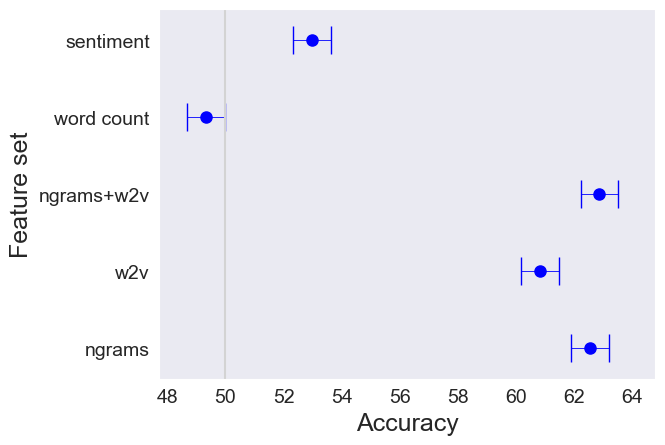

In [24]:
# Import the pyplot module from matplotlib
from matplotlib import pyplot as plt

# Create a new figure
fig = plt.figure()

# Create an error bar plot
# The y-values are the names of the feature sets used by each model
# The x-values are the accuracy estimates for each model
# The x-errors are the errors of the accuracy estimates for each model
# The format of the markers is 'o' (circle), the color of the markers is blue, the line width of the error bars is 0.6, the size of the markers is 8, and the length of the error bar caps is 10
plt.errorbar(y = plot_dat['features'], x = plot_dat['acc'], xerr=plot_dat['err'], fmt="o", color="b", elinewidth=.6, markersize=8, capsize=10)

# Disable the grid
plt.grid(False)

# Draw a vertical line at x=50
# The color of the line is light grey and the line style is '-'
plt.axvline(x=50, color='lightgrey', linestyle='-')

# Set the labels of the x-axis and y-axis
plt.xlabel('Accuracy', fontsize=18)
plt.ylabel('Feature set', fontsize=18)

# Set the margins of the plot
# The x-margin is 0.1 and the y-margin is automatically adjusted to be tight
plt.margins(0.1, tight=True)

# Set the limits of the x-axis
# The right limit is the maximum accuracy plus the maximum error, multiplied by 1.02
# The left limit is the minimum accuracy minus the minimum error, multiplied by 0.98
plt.xlim(right=((max(plot_dat['acc']) + max(plot_dat['err']))) * 1.02,
         left=((min(plot_dat['acc']) - min(plot_dat['err']))) * 0.98)

# Set the font size of the x-ticks and y-ticks to 14
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Display the plot
plt.show()